In [ ]:
# 218015230 - Kailin Reddy
# Low resource machine translation

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
from string import digits
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [ ]:
d = pd.read_excel('/content/drive/MyDrive/COMP700/1-2.xlsx')
d.head()

,Source.Name,Column1,Column2
0,englishzulu00001.xlsx,UKZN Lecturer Wins Best Animated Film Award at...,Uthisha wase-UKZN Uhlabane Ngendondo Yefilimu ...
1,englishzulu00001.xlsx,Lecturer in the School of Arts Ms Michelle Ste...,Uthisha waseSikoleni SezobuCiko uNkz Michelle ...
2,englishzulu00001.xlsx,The film was selected from 857 international e...,Leli filimu likhethwe kwangama-857 njengelivel...
3,englishzulu00001.xlsx,‘I am still in disbelief but really excited th...,‘Angikakakholwa namanje kodwa ngithokoze kakhu...
4,englishzulu00001.xlsx,‘I was very surprised to win as I wasn’t expec...,‘Bengingakulindele ukunqoba nhlobo.’


In [ ]:
d.drop('Source.Name', inplace = True, axis=1)
d.columns = ['English', 'isiZulu']
d.head()

,English,isiZulu
0,UKZN Lecturer Wins Best Animated Film Award at...,Uthisha wase-UKZN Uhlabane Ngendondo Yefilimu ...
1,Lecturer in the School of Arts Ms Michelle Ste...,Uthisha waseSikoleni SezobuCiko uNkz Michelle ...
2,The film was selected from 857 international e...,Leli filimu likhethwe kwangama-857 njengelivel...
3,‘I am still in disbelief but really excited th...,‘Angikakakholwa namanje kodwa ngithokoze kakhu...
4,‘I was very surprised to win as I wasn’t expec...,‘Bengingakulindele ukunqoba nhlobo.’


In [ ]:
d = d[~pd.isnull(d['English'])]
d.drop_duplicates(inplace=True)
d[['English']] = d[['English']].astype(str)
d[['isiZulu']] = d[['isiZulu']].astype(str)

spcl = set(string.punctuation) #Special chars
dgt = str.maketrans('', '', digits) #Digits

# Convert to lowercase
d['English']=d['English'].apply(lambda x: x.lower())
d['isiZulu']=d['isiZulu'].apply(lambda x: x.lower())

# Remove quotes
d['English']=d['English'].apply(lambda x: re.sub("'", '', x))
d['isiZulu']=d['isiZulu'].apply(lambda x: re.sub("'", '', x))

#Remove all special chars
d['English']=d['English'].apply(lambda x: ''.join(ch for ch in x if ch not in spcl))
d['isiZulu']=d['isiZulu'].apply(lambda x: ''.join(ch for ch in x if ch not in spcl))

# Remove all numbers
d['English']=d['English'].apply(lambda x: x.translate(dgt))
d['isiZulu']=d['isiZulu'].apply(lambda x: x.translate(dgt))

# Remove extra spaces
d['English']=d['English'].apply(lambda x: x.strip())
d['isiZulu']=d['isiZulu'].apply(lambda x: x.strip())
d['English']=d['English'].apply(lambda x: re.sub(" +", " ", x))
d['isiZulu']=d['isiZulu'].apply(lambda x: re.sub(" +", " ", x))

d['isiZulu'] = d['isiZulu'].apply(lambda x: 'START_ ' + x + ' _END')

d['English length'] = d['English'].apply(lambda x:len(x.split(" ")))
d['isiZulu length'] = d['isiZulu'].apply(lambda x:len(x.split(" ")))
d.shape


(6993, 4)

In [ ]:
d.head()

In [ ]:
allEngWords = set()
for e in d['English']:
  for word in e.split():
    if word not in allEngWords:
      allEngWords.add(word)

allZuluWords = set()
for z in d['isiZulu']:
  for word in z.split():
    if word not in allZuluWords:
      allZuluWords.add(word)

In [ ]:
text_map = {'English': d['English'], 'isiZulu':d['isiZulu']}

def dataframe_text(text_map):
    text_df=pd.DataFrame(text_map,columns=text_map.keys())
    for key in text_map.keys():
        text_df[key+' length']=text_df[key].apply(lambda text:len(text.split()))
    text_df=text_df.sample(frac=1)
    return text_df

text_df=dataframe_text(text_map)
text_df.head()

,English,isiZulu,English length,isiZulu length
1934,in their hectic schedule of marketing their ne...,START_ ohlelweni lwabo olumatasa lokukhangisa ...,27,23
2958,i am interested in finding ways to improve hea...,START_ nginesifiso sokuthola izindlela zokuthu...,16,11
2479,as we discuss the story of the blind men and t...,START_ njengoba sichaza indaba yamadoda ayizim...,24,14
2723,the xhosa were a great people – tall athletic ...,START_ abakwaxhosa babengabantu abakhulu – beb...,13,11
7251,• completion of a bed undergraduate residence ...,START_ • ukuphothulwa okungama kwendawo yokuhl...,12,13


In [ ]:
encoder_seq_length=max(text_df['English length'])
decoder_seq_length=max(text_df['isiZulu length'])

num_encoder_tokens=len(allEngWords)
num_decoder_tokens=len(allZuluWords)+1

In [ ]:
english_lookup_table={word:num for num,word in enumerate(allEngWords)}
zulu_lookup_table={word:num+1 for num,word in enumerate(allZuluWords)}

In [ ]:
english_token_lookup_table={num:word for word,num in english_lookup_table.items()}
zulu_token_lookup_table={num:word for word,num in zulu_lookup_table.items()}

In [ ]:
def generate_batch(X,y,batch_size=32):
    while True:
        for i in range(0,len(X),batch_size):
            encoder_input_vector=np.zeros((batch_size,encoder_seq_length),dtype=np.float32)
            decoder_input_vector=np.zeros((batch_size,decoder_seq_length),dtype=np.float32)
            decoder_target_vector=np.zeros((batch_size,decoder_seq_length,num_decoder_tokens),dtype=np.float32)
            for j,(encoder_text,decoder_text) in enumerate(zip(X[i:i+batch_size],y[i:i+batch_size])):
                for time_step,encoder_word in enumerate(encoder_text.split()):
                    encoder_input_vector[j,time_step]=english_lookup_table[encoder_word]
                for time_step,decoder_word in enumerate(decoder_text.split()):
                    if time_step<len(decoder_text.split())-1:
                        decoder_input_vector[j,time_step]=zulu_lookup_table[decoder_word]
                    if time_step>0:
                        decoder_target_vector[j,time_step-1,zulu_lookup_table[decoder_word]]=1
            yield ([encoder_input_vector,decoder_input_vector],decoder_target_vector)

In [ ]:
X=list(text_df['English'])
y=list(text_df['isiZulu'])

In [ ]:
X_train=X[:len(X)*80//100]
y_train=y[:len(y)*80//100]
X_valid=X[80*len(X)//100:]
y_valid=y[80*len(y)//100:]

latent_dim=512
embedding_dim=256
batch_size=128

In [ ]:
encoder_inputs=layers.Input(shape=(None,))
encoder_embedding_layer=layers.Embedding(
    input_dim=num_encoder_tokens,output_dim=embedding_dim,
    mask_zero=True
)
encoder_embeddings=encoder_embedding_layer(encoder_inputs)
encoder_lstm=layers.Bidirectional(layers.LSTM(units=latent_dim,return_state=True))
_,encoder_hidden_state1,encoder_cell_state1,encoder_hidden_state2,encoder_cell_state2=encoder_lstm(encoder_embeddings)
encoder_state=[encoder_hidden_state1+encoder_hidden_state2,encoder_cell_state1+encoder_cell_state2]


decoder_inputs=layers.Input(shape=(None,))
decoder_embedding_layer=layers.Embedding(
    input_dim=num_decoder_tokens,output_dim=embedding_dim,
    mask_zero=True
)
decoder_embeddings=decoder_embedding_layer(decoder_inputs)
decoder_lstm=layers.LSTM(units=latent_dim,return_sequences=True,return_state=True)
decoder_output,_,_=decoder_lstm(decoder_embeddings,initial_state=encoder_state)
output_layer=layers.Dense(units=num_decoder_tokens)
decoder_output=output_layer(decoder_output)
output_probs=tf.nn.softmax(decoder_output)


model=tf.keras.models.Model(inputs=(encoder_inputs,decoder_inputs),outputs=output_probs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    2967296     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 1024),       3149824     ['embedding[0][0]']              
                                 (None, 512),                                                 

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy')

In [ ]:
history=model.fit(
    x=generate_batch(X_train,y_train),
    validation_data=generate_batch(X_valid,y_valid),
    batch_size=batch_size,
    epochs=5,
    steps_per_epoch=len(X_train)//batch_size,
    validation_steps=len(X_valid)//batch_size
)

Epoch 1/5
48/48 [==============================] - 50s 730ms/step - loss: 1.4101 - val_loss: 1.3446
Epoch 2/5
48/48 [==============================] - 31s 643ms/step - loss: 1.2762 - val_loss: 1.2849
Epoch 3/5
48/48 [==============================] - 29s 592ms/step - loss: 1.3521 - val_loss: 1.3099
Epoch 4/5
48/48 [==============================] - 29s 589ms/step - loss: 1.3505 - val_loss: 1.3600
Epoch 5/5
48/48 [==============================] - 30s 630ms/step - loss: 1.2230 - val_loss: 1.3120


In [ ]:
encoder_model=tf.keras.models.Model(inputs=encoder_inputs,outputs=encoder_state)

In [ ]:
decoder_hidden_state=layers.Input(shape=(latent_dim,))
decoder_cell_state=layers.Input(shape=(latent_dim,))
decoder_init_state=[decoder_hidden_state,decoder_cell_state]
decoder_embeddings=decoder_embedding_layer(decoder_inputs)
decoder_output,decoder_output_hidden_state,decoder_output_cell_state=decoder_lstm(decoder_embeddings
                                                                    ,initial_state=decoder_init_state)
decoder_final_state=[decoder_output_hidden_state,decoder_output_cell_state]
decoder_output=output_layer(decoder_output)
decoder_probs=tf.nn.softmax(decoder_output)
decoder_model=tf.keras.models.Model(inputs=[decoder_inputs]+decoder_init_state
                                    ,outputs=[decoder_probs]+decoder_final_state)

In [ ]:
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    2967296     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 1024),       3149824     ['embedding[0][0]']              
                                 (None, 512),                                                     
                                 (None, 512),                                                     
                                 (None, 512),                                               

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    6850560     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                            

In [ ]:
def generate_text(text):
    translation=""
    states_value=encoder_model(text)
    target=np.zeros((1,1))
    target[0,0]=zulu_lookup_table['START_']
    stop_condition=False
    while not stop_condition:
        output_token,hidden_state,cell_state=decoder_model([target]+states_value)
        char_index=np.argmax(output_token[0,-1,:])
        char=zulu_token_lookup_table[char_index]
        if char=='_END' or len(translation)>=decoder_seq_length:
            stop_condition=True
            continue
        translation+=' '+char
        states_value=[hidden_state,cell_state]
        target[0,0]=zulu_lookup_table[char]
    return translation

In [ ]:
text_gen=generate_batch(X_valid,y_valid,batch_size=1)
text_gen
k=-1

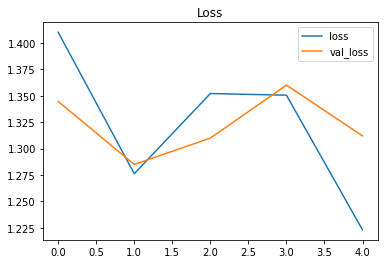

In [ ]:
pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

In [ ]:
k+=1
[encoder_inputs,decoder_inputs],decoder_target=next(text_gen)
print(f'Input sentence: {X_valid[k:k+1][0]}')
print(f'Actual translation: {y_valid[k:k+1][0][5:-5]}')
print(f"Model's translation: {generate_text(encoder_inputs)}" )

Input sentence: senate considered a number of significant matters during
Actual translation: _ izigele zidingide izindaba eziningi ezibalulekile kunyaka wezi
Model's translation:  • ukuthi


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
test_eng_texts = [pair[0] for pair in y_valid]
test_zul_texts = [pair[1] for pair in y_valid]
score = 0
bleu  = 0
for i in range(10):
    
    candidate = y_valid[i]
    
    reference = test_zul_texts[i].lower()
    print(candidate,reference)
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu+=score
    print(f"Score:{score}")
print(f"\nBLEU score : {round(bleu,2)}/10")

START_ izigele zidingide izindaba eziningi ezibalulekile kunyaka wezi _END t
Score:0
START_ njengoba luxhaswe yibristolmyers squibb foundation bmsf abaphenyi abakhulu balolu hlelo udkt themba ginindza onguthisha eukzn futhi ofundele ukuhlola ukusabalala nokulawulwa kwezifo nomqondisi wezokwelapha weampath oncology and haematology programme emoi university ekenya usolwazi chite asirwe _END t
Score:0.0032679738562091504
START_ uhlelo lwasemini belunezinhlelo ebezibanjelwe emitapweni yolwazi emine esemiphakathini austerville westville chesterville extension nasothongathi _END t
Score:0.006369426751592359
START_ lezi ezinye zezinhlelo zangonyaka wezi _END t
Score:0
START_ inyuvesi ikleliswe yaba ngeyama kwiemerging economies ranking yethe _END t
Score:0.012658227848101266
START_ uhlaka lokubuyekezwa kwezinqubomgomo ludingidiwe futhi lagunyazwa iemc nekomidi lezokuqasha _END t
Score:0.009708737864077669
START_ ukubona ngokufanele izimpilo zezingane okuholela ekuqondeni kwabasesifundeni naku